<h1 align="center"> <strong>🗳️ Voting Ensemble - Complete Guide</strong> </h1>

This notebook provides a comprehensive introduction to Voting Ensemble methods, covering:
- Hard voting vs Soft voting concepts
- Implementation from scratch
- Scikit-learn VotingClassifier and VotingRegressor
- Weighted voting strategies
- Model diversity and selection
- Performance comparison and best practices

---

## **📚 1. Import Libraries and Setup**

In [17]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Machine learning
from sklearn.datasets import  make_regression, load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV , StratifiedKFold
from sklearn.ensemble import (
    VotingClassifier, VotingRegressor,
    RandomForestClassifier, RandomForestRegressor
)
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, 
    mean_squared_error, r2_score
)

# Visualization settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## **🗳️ 2. Conceptual Foundation**

### **What is Voting Ensemble?** 🤔

**Voting Ensemble** is a simple but effective ensemble method that combines predictions from multiple models by taking a **majority vote** (hard voting) or **averaging probabilities** (soft voting).

### **Types of Voting:**

#### **1. Hard Voting (Majority Rule)**
- Each model makes a class prediction
- Final prediction = majority vote
- Works with any classifier

#### **2. Soft Voting (Probability Averaging)**
- Each model outputs class probabilities
- Final prediction = class with highest average probability
- Generally performs better than hard voting
- Requires models that output probabilities

### **Mathematical Foundation:**

#### Hard Voting:
For $K$ classifiers $h_1, h_2, ..., h_K$:
$$\hat{y} = \arg\max_c \sum_{k=1}^{K} \mathbb{I}(h_k(x) = c)$$

#### Soft Voting:
For probability estimates $p_{k,c}(x)$ from classifier $k$ for class $c$:
$$\hat{y} = \arg\max_c \frac{1}{K} \sum_{k=1}^{K} p_{k,c}(x)$$

#### Weighted Voting:
With weights $w_k$ for each classifier:
$$\hat{y} = \arg\max_c \sum_{k=1}^{K} w_k \cdot p_{k,c}(x)$$

### **Key Requirements:**
- **Diversity**: Models should make different types of errors
- **Independence**: Models should be trained on different aspects
- **Competence**: Each model should be better than random guessing

### **Advantages:**
- ✅ Simple to understand and implement
- ✅ Reduces overfitting
- ✅ Often improves performance
- ✅ Computationally efficient

### **Disadvantages:**
- ❌ Equal weight to all models (unless weighted)
- ❌ May not capture complex model interactions
- ❌ Performance limited by weakest models

## **📊 3. Use Cases and When to Use Voting**

### **Ideal Use Cases:**
- **Model diversity**: When you have models with different strengths
- **Quick ensemble**: Need fast, simple ensemble method
- **Baseline ensemble**: Starting point for more complex ensembles
- **Risk reduction**: Reduce chance of poor single-model performance

### **When NOT to Use:**
- **Highly correlated models**: When models make similar predictions
- **Large performance gaps**: When one model significantly outperforms others
- **Need interpretability**: Voting reduces model interpretability

## **🔧 4. Implementation from Scratch**

Let's implement voting ensemble from scratch to understand the mechanics.

In [3]:
class VotingEnsemble:
    def __init__(self, models, voting='hard', weights=None):
        """
        Voting Ensemble implementation from scratch
        
        Parameters:
        - models: list of (name, model) tuples
        - voting: 'hard' or 'soft'
        - weights: list of weights for each model
        """
        self.models = models
        self.voting = voting
        self.weights = weights if weights else [1.0] * len(models)
        self.trained_models = []
        
    def fit(self, X, y):
        """Train all base models"""
        self.trained_models = []
        
        for name, model in self.models:
            # Clone and train model
            trained_model = model.fit(X, y)
            self.trained_models.append((name, trained_model))
            
        return self
    
    def predict(self, X):
        """Make predictions using voting"""
        if self.voting == 'hard':
            return self._hard_voting_predict(X)
        else:
            return self._soft_voting_predict(X)
    
    def _hard_voting_predict(self, X):
        """Hard voting implementation"""
        predictions = np.array([model.predict(X) for name, model in self.trained_models])
        
        # Apply weights to votes
        weighted_predictions = []
        for i in range(len(X)):
            votes = {}
            for j, (name, model) in enumerate(self.trained_models):
                pred = predictions[j][i]
                votes[pred] = votes.get(pred, 0) + self.weights[j]
            
            # Get class with most weighted votes
            final_pred = max(votes, key=votes.get)
            weighted_predictions.append(final_pred)
            
        return np.array(weighted_predictions)
    
    def _soft_voting_predict(self, X):
        """Soft voting implementation"""
        # Get probability predictions from all models
        probabilities = []
        for name, model in self.trained_models:
            if hasattr(model, 'predict_proba'):
                probabilities.append(model.predict_proba(X))
            else:
                raise ValueError(f"Model {name} doesn't support predict_proba for soft voting")
        
        # Weighted average of probabilities
        weighted_probs = np.zeros_like(probabilities[0])
        total_weight = sum(self.weights)
        
        for i, prob in enumerate(probabilities):
            weighted_probs += prob * self.weights[i] / total_weight
            
        # Return class with highest probability
        return np.argmax(weighted_probs, axis=1)
    
    def predict_proba(self, X):
        """Get probability estimates for soft voting"""
        if self.voting != 'soft':
            raise ValueError("predict_proba only available for soft voting")
            
        probabilities = []
        for name, model in self.trained_models:
            probabilities.append(model.predict_proba(X))
        
        # Weighted average of probabilities
        weighted_probs = np.zeros_like(probabilities[0])
        total_weight = sum(self.weights)
        
        for i, prob in enumerate(probabilities):
            weighted_probs += prob * self.weights[i] / total_weight
            
        return weighted_probs

print("✅ Custom VotingEnsemble class created!")

✅ Custom VotingEnsemble class created!


## **📊 5. Classification Example with Scikit-learn**

Let's demonstrate voting ensemble for classification using the breast cancer dataset.

In [5]:
# Load and prepare data
data = load_breast_cancer()
X, y = data.data, data.target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features for SVM and KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Dataset shape : {X.shape}")
print(f"Train set     : {X_train.shape}")
print(f"Test  set     : {X_test.shape}")
print(f"Classes       : {np.unique(y)}")

Dataset shape : (569, 30)
Train set     : (455, 30)
Test  set     : (114, 30)
Classes       : [0 1]


In [6]:
# Create diverse base models
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(probability=True, random_state=42)  # Enable probability for soft voting
nb_clf = GaussianNB()
knn_clf = KNeighborsClassifier(n_neighbors=5)

# Train individual models and evaluate
models = {
    'Random Forest': (rf_clf, X_train, X_test),
    'SVM': (svm_clf, X_train_scaled, X_test_scaled),
    'Naive Bayes': (nb_clf, X_train, X_test),
    'KNN': (knn_clf, X_train_scaled, X_test_scaled)
}

individual_scores = {}
trained_models = {}

print("=== Individual Model Performance ===")
for name, (model, X_tr, X_te) in models.items():
    # Train model
    model.fit(X_tr, y_train)
    
    # Make predictions
    y_pred = model.predict(X_te)
    accuracy = accuracy_score(y_test, y_pred)
    
    individual_scores[name] = accuracy
    trained_models[name] = model
    
    print(f"{name}: {accuracy:.4f}")

print(f"\nAverage individual accuracy: {np.mean(list(individual_scores.values())):.4f}")

=== Individual Model Performance ===
Random Forest: 0.9561
SVM: 0.9825
Naive Bayes: 0.9386
KNN: 0.9561

Average individual accuracy: 0.9583


In [7]:
# Create voting ensembles
# For models that need scaled data, we'll use a pipeline approach
from sklearn.pipeline import Pipeline

# Create pipelines for models that need scaling
svm_pipeline = Pipeline([('scaler', StandardScaler()), ('svm', SVC(probability=True, random_state=42))])
knn_pipeline = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=5))])

# Define estimators for voting
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', svm_pipeline),
    ('nb', GaussianNB()),
    ('knn', knn_pipeline)
]

# Hard Voting Classifier
hard_voting_clf = VotingClassifier(
    estimators=estimators,
    voting='hard'
)

# Soft Voting Classifier
soft_voting_clf = VotingClassifier(
    estimators=estimators,
    voting='soft'
)

# Train voting classifiers
print("Training voting ensembles...")
hard_voting_clf.fit(X_train, y_train)
soft_voting_clf.fit(X_train, y_train)

# Make predictions
hard_pred = hard_voting_clf.predict(X_test)
soft_pred = soft_voting_clf.predict(X_test)

# Evaluate voting ensembles
hard_accuracy = accuracy_score(y_test, hard_pred)
soft_accuracy = accuracy_score(y_test, soft_pred)

print("\n=== Voting Ensemble Performance ===")
print(f"Hard Voting Accuracy: {hard_accuracy:.4f}")
print(f"Soft Voting Accuracy: {soft_accuracy:.4f}")
print(f"\nImprovement over average individual:")
print(f"Hard Voting: +{hard_accuracy - np.mean(list(individual_scores.values())):.4f}")
print(f"Soft Voting: +{soft_accuracy - np.mean(list(individual_scores.values())):.4f}")

Training voting ensembles...

=== Voting Ensemble Performance ===
Hard Voting Accuracy: 0.9649
Soft Voting Accuracy: 0.9474

Improvement over average individual:
Hard Voting: +0.0066
Soft Voting: +-0.0110


## **📈 6. Weighted Voting Example**

Let's demonstrate how to use weighted voting to give more importance to better-performing models.

In [8]:
# Calculate weights based on individual model performance
# Higher accuracy = higher weight
base_accuracies = []
for name, (model, X_tr, X_te) in models.items():
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    accuracy = accuracy_score(y_test, y_pred)
    base_accuracies.append(accuracy)

# Convert accuracies to weights (normalize)
weights = np.array(base_accuracies) / np.sum(base_accuracies)

print("=== Model Weights Based on Performance ===")
for i, (name, _) in enumerate(estimators):
    print(f"{name}: {weights[i]:.3f} (accuracy: {base_accuracies[i]:.4f})")

# Create weighted soft voting classifier
weighted_voting_clf = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=weights
)

# Train and evaluate
weighted_voting_clf.fit(X_train, y_train)
weighted_pred = weighted_voting_clf.predict(X_test)
weighted_accuracy = accuracy_score(y_test, weighted_pred)

print(f"\nWeighted Soft Voting Accuracy: {weighted_accuracy:.4f}")
print(f"Improvement over equal weights: +{weighted_accuracy - soft_accuracy:.4f}")

=== Model Weights Based on Performance ===
rf: 0.249 (accuracy: 0.9561)
svm: 0.256 (accuracy: 0.9825)
nb: 0.245 (accuracy: 0.9386)
knn: 0.249 (accuracy: 0.9561)

Weighted Soft Voting Accuracy: 0.9474
Improvement over equal weights: +0.0000


## **📊 7. Regression Example**

Let's demonstrate voting ensemble for regression tasks.

In [9]:
# Create regression dataset
X_reg, y_reg = make_regression( n_samples=1000, n_features=10, noise=0.1, random_state=42)

# Split the data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Scale features
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

print(f"Regression dataset shape: {X_reg.shape}")
print(f"Target range: [{y_reg.min():.2f}, {y_reg.max():.2f}]")

Regression dataset shape: (1000, 10)
Target range: [-449.01, 411.14]


In [10]:
# Create diverse regression models
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
svr_reg = SVR()
linear_reg = LinearRegression()
knn_reg = KNeighborsRegressor(n_neighbors=5)

# Create pipelines for models that need scaling
svr_pipeline = Pipeline([('scaler', StandardScaler()), ('svr', SVR())])
knn_reg_pipeline = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor(n_neighbors=5))])

# Define estimators for voting regressor
reg_estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('svr', svr_pipeline),
    ('linear', LinearRegression()),
    ('knn', knn_reg_pipeline)
]

# Train individual regressors
print("=== Individual Regressor Performance ===")
individual_r2_scores = {}

for name, model in reg_estimators:
    # Train model
    model.fit(X_train_reg, y_train_reg)
    
    # Make predictions
    y_pred_reg = model.predict(X_test_reg)
    r2 = r2_score(y_test_reg, y_pred_reg)
    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
    
    individual_r2_scores[name] = r2
    
    print(f"{name}: R² = {r2:.4f}, RMSE = {rmse:.4f}")

=== Individual Regressor Performance ===
rf: R² = 0.8464, RMSE = 50.9082
svr: R² = 0.2478, RMSE = 112.6534
linear: R² = 1.0000, RMSE = 0.0975
knn: R² = 0.7783, RMSE = 61.1639


In [12]:
# Create Voting Regressor
voting_regressor = VotingRegressor(estimators=reg_estimators)

# Train and evaluate
voting_regressor.fit(X_train_reg, y_train_reg)
voting_pred_reg = voting_regressor.predict(X_test_reg)

voting_r2 = r2_score(y_test_reg, voting_pred_reg)
voting_rmse = np.sqrt(mean_squared_error(y_test_reg, voting_pred_reg))

print("=== Voting Regressor Performance ===")
print(f"Voting Regressor: R² = {voting_r2:.4f}, RMSE = {voting_rmse:.4f}")
print(f"Average individual R²: {np.mean(list(individual_r2_scores.values())):.4f}")
print(f"Improvement: +{voting_r2 - np.mean(list(individual_r2_scores.values())):.4f}")

=== Voting Regressor Performance ===
Voting Regressor: R² = 0.8463, RMSE = 50.9230
Average individual R²: 0.7181
Improvement: +0.1282


## **🎯 8. Model Diversity Analysis**

Let's analyze how model diversity affects voting ensemble performance.

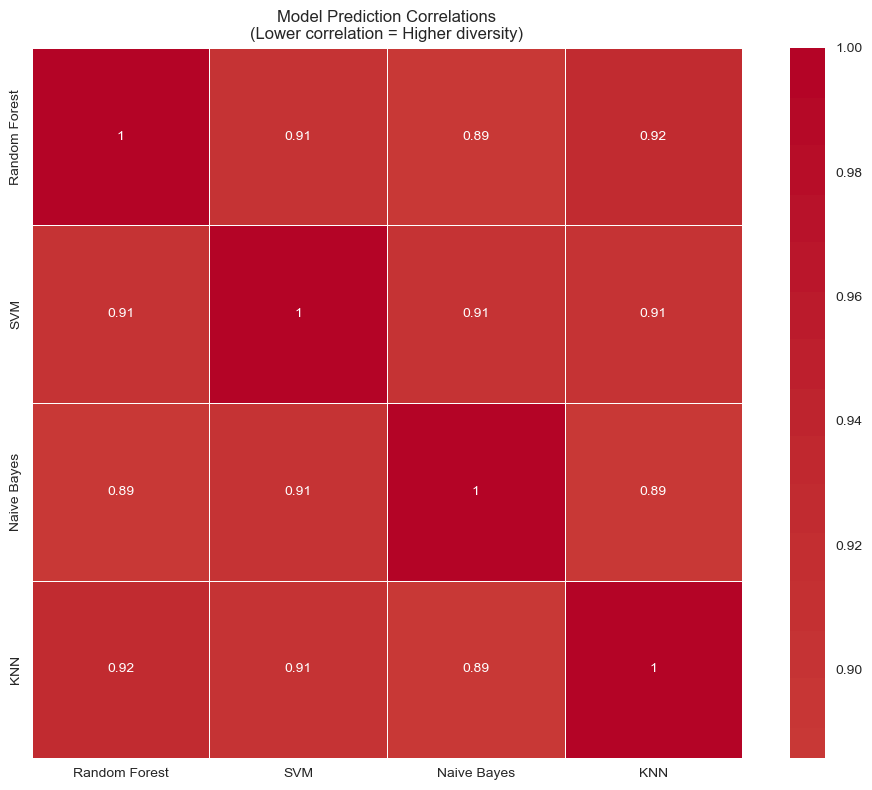

Average pairwise correlation: 0.902
Diversity score (1 - correlation): 0.098


In [13]:
# Get predictions from all models
predictions = {}
probabilities = {}

for name, (model, X_tr, X_te) in models.items():
    model.fit(X_tr, y_train)
    predictions[name] = model.predict(X_te)
    if hasattr(model, 'predict_proba'):
        probabilities[name] = model.predict_proba(X_te)[:, 1]  # Probability of positive class

# Create correlation matrix of predictions
pred_df = pd.DataFrame(predictions)
correlation_matrix = pred_df.corr()

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,square=True, linewidths=0.5)
plt.title('Model Prediction Correlations\n(Lower correlation = Higher diversity)')
plt.tight_layout()
plt.show()

# Calculate average correlation (diversity metric)
avg_correlation = correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)].mean()
print(f"Average pairwise correlation: {avg_correlation:.3f}")
print(f"Diversity score (1 - correlation): {1 - avg_correlation:.3f}")

## **⚙️ 9. Hyperparameter Tuning**

Let's optimize the voting ensemble by tuning base model parameters.

In [14]:
# Define parameter grid for voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(random_state=42)),
        ('svm', Pipeline([('scaler', StandardScaler()), ('svm', SVC(probability=True, random_state=42))])),
        ('nb', GaussianNB())
    ],
    voting='soft'
)

# Parameter grid for GridSearch
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [5, 10, None],
    'svm__svm__C': [0.1, 1, 10],
    'svm__svm__gamma': ['scale', 'auto'],
    'nb__var_smoothing': [1e-9, 1e-8, 1e-7]
}

# Perform grid search (using a smaller subset for speed)
print("Performing hyperparameter tuning...")
grid_search = GridSearchCV(
    voting_clf,
    param_grid,
    cv=3,  # Reduced for faster execution
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit on a subset for demonstration
subset_size = 200
X_subset = X_train[:subset_size]
y_subset = y_train[:subset_size]

grid_search.fit(X_subset, y_subset)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate best model on full test set
best_voting_clf = grid_search.best_estimator_
best_voting_clf.fit(X_train, y_train)
best_pred = best_voting_clf.predict(X_test)
best_accuracy = accuracy_score(y_test, best_pred)

print(f"Tuned voting classifier accuracy: {best_accuracy:.4f}")

Performing hyperparameter tuning...
Fitting 3 folds for each of 162 candidates, totalling 486 fits

Best parameters: {'nb__var_smoothing': 1e-07, 'rf__max_depth': 5, 'rf__n_estimators': 50, 'svm__svm__C': 1, 'svm__svm__gamma': 'scale'}
Best cross-validation score: 0.9698
Tuned voting classifier accuracy: 0.9649


## **📊 10. Visualization and Analysis**

Let's create comprehensive visualizations to understand voting ensemble behavior.

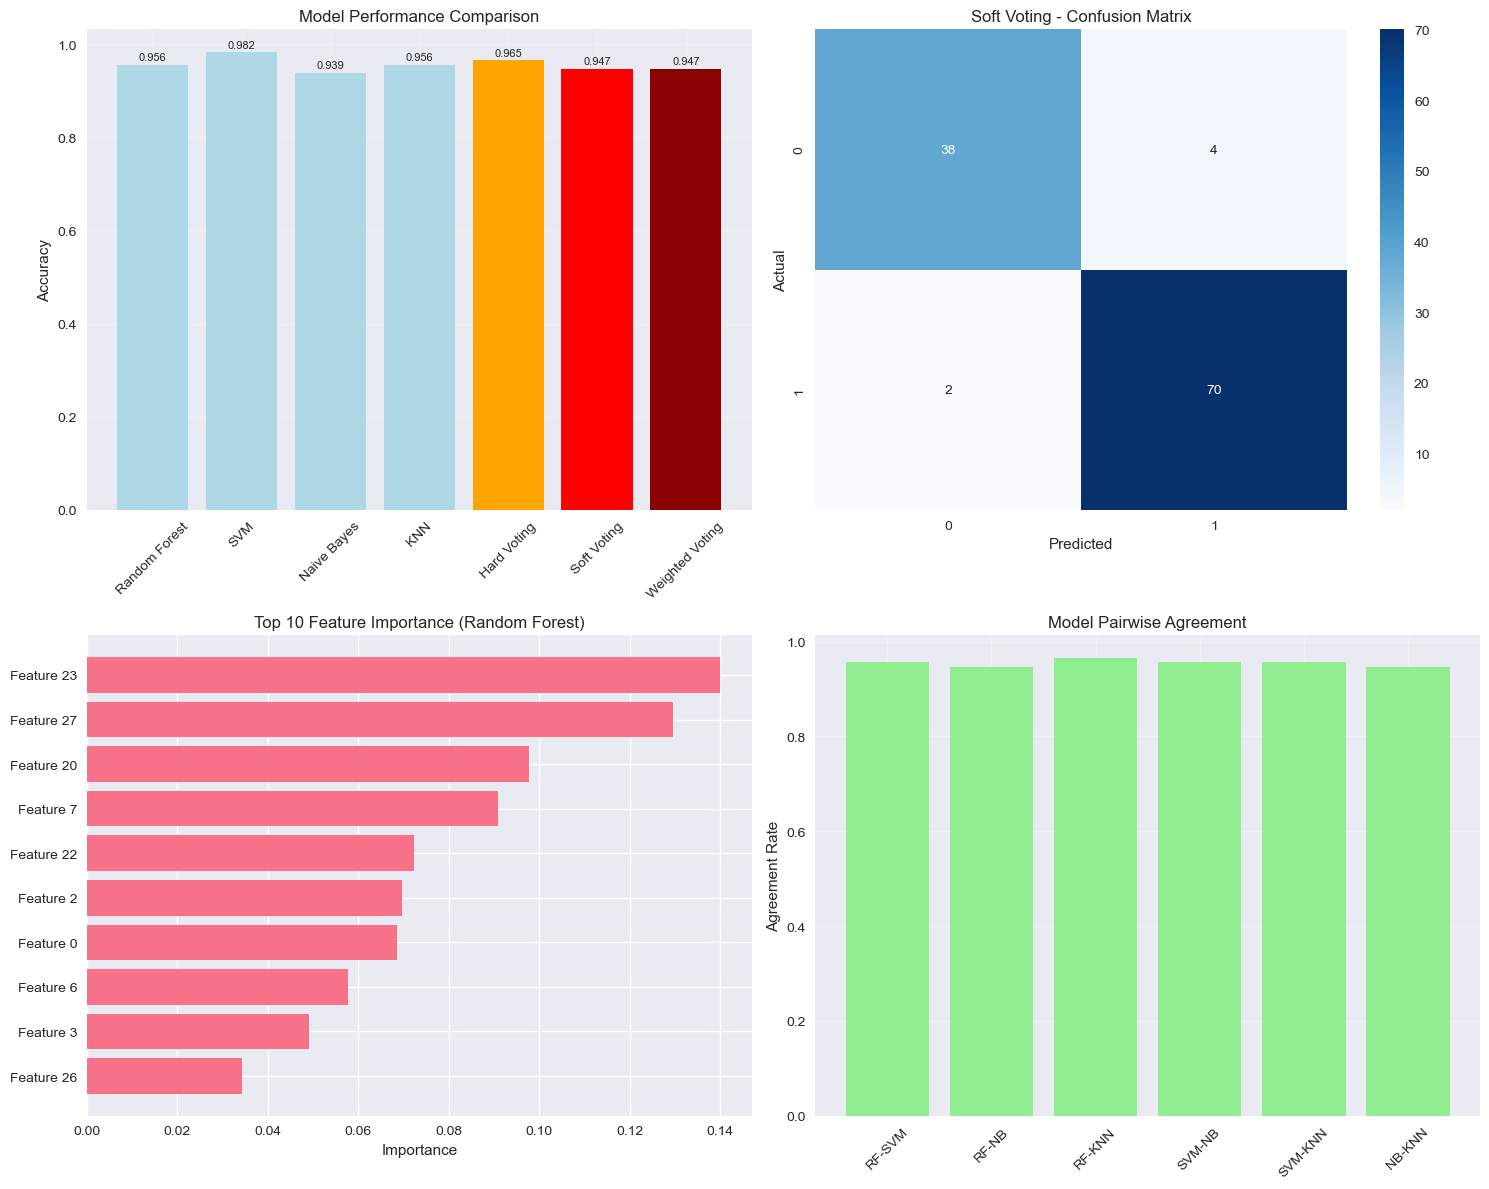

In [15]:
# Create comprehensive comparison plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Model Accuracy Comparison
all_scores = list(individual_scores.values()) + [hard_accuracy, soft_accuracy, weighted_accuracy]
all_names = list(individual_scores.keys()) + ['Hard Voting', 'Soft Voting', 'Weighted Voting']
colors = ['lightblue'] * len(individual_scores) + ['orange', 'red', 'darkred']

axes[0, 0].bar(range(len(all_scores)), all_scores, color=colors)
axes[0, 0].set_xticks(range(len(all_names)))
axes[0, 0].set_xticklabels(all_names, rotation=45)
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Model Performance Comparison')
axes[0, 0].grid(True, alpha=0.3)

# Add value labels on bars
for i, score in enumerate(all_scores):
    axes[0, 0].text(i, score + 0.005, f'{score:.3f}', ha='center', va='bottom', fontsize=8)

# 2. Confusion Matrix for Best Voting Classifier
cm = confusion_matrix(y_test, soft_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title('Soft Voting - Confusion Matrix')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

# 3. Feature Importance (from Random Forest in ensemble)
rf_importance = soft_voting_clf.named_estimators_['rf'].feature_importances_
feature_indices = np.argsort(rf_importance)[-10:]  # Top 10 features
axes[1, 0].barh(range(len(feature_indices)), rf_importance[feature_indices])
axes[1, 0].set_yticks(range(len(feature_indices)))
axes[1, 0].set_yticklabels([f'Feature {i}' for i in feature_indices])
axes[1, 0].set_xlabel('Importance')
axes[1, 0].set_title('Top 10 Feature Importance (Random Forest)')

# 4. Model Agreement Analysis
# Calculate how often models agree
agreement_scores = []
model_names_short = ['RF', 'SVM', 'NB', 'KNN']

for i in range(len(model_names_short)):
    for j in range(i+1, len(model_names_short)):
        name1 = list(predictions.keys())[i]
        name2 = list(predictions.keys())[j]
        agreement = np.mean(predictions[name1] == predictions[name2])
        agreement_scores.append(agreement)

pair_names = []
for i in range(len(model_names_short)):
    for j in range(i+1, len(model_names_short)):
        pair_names.append(f'{model_names_short[i]}-{model_names_short[j]}')

axes[1, 1].bar(range(len(agreement_scores)), agreement_scores, color='lightgreen')
axes[1, 1].set_xticks(range(len(pair_names)))
axes[1, 1].set_xticklabels(pair_names, rotation=45)
axes[1, 1].set_ylabel('Agreement Rate')
axes[1, 1].set_title('Model Pairwise Agreement')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## **🔍 11. Advanced Voting Strategies**

Let's explore more sophisticated voting strategies.

In [16]:
# Dynamic Weighted Voting based on confidence
class ConfidenceWeightedVoting:
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        # Train all models
        for name, model in self.models:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = []
        
        for i in range(len(X)):
            sample_predictions = []
            confidences = []
            
            # Get predictions and confidences for this sample
            for name, model in self.models:
                if hasattr(model, 'predict_proba'):
                    proba = model.predict_proba(X[i:i+1])[0]
                    pred = np.argmax(proba)
                    confidence = np.max(proba)  # Confidence = max probability
                else:
                    pred = model.predict(X[i:i+1])[0]
                    confidence = 0.5  # Default confidence for models without probabilities
                
                sample_predictions.append(pred)
                confidences.append(confidence)
            
            # Weight votes by confidence
            weighted_votes = {}
            for pred, conf in zip(sample_predictions, confidences):
                weighted_votes[pred] = weighted_votes.get(pred, 0) + conf
            
            # Choose class with highest weighted vote
            final_pred = max(weighted_votes, key=weighted_votes.get)
            predictions.append(final_pred)
            
        return np.array(predictions)

# Test confidence-weighted voting
conf_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('nb', GaussianNB())
]

conf_voting = ConfidenceWeightedVoting(conf_models)
conf_voting.fit(X_train, y_train)
conf_pred = conf_voting.predict(X_test)
conf_accuracy = accuracy_score(y_test, conf_pred)

print(f"Confidence-weighted voting accuracy: {conf_accuracy:.4f}")

Confidence-weighted voting accuracy: 0.9474


## **📊 12. Cross-Validation Analysis**

Let's perform thorough cross-validation to assess voting ensemble stability.

Performing 5-fold cross-validation...
Random Forest: 0.9561 (+/- 0.0247)
SVM: 0.9772 (+/- 0.0325)
Naive Bayes: 0.9385 (+/- 0.0469)
Hard Voting: 0.9614 (+/- 0.0377)
Soft Voting: 0.9543 (+/- 0.0462)


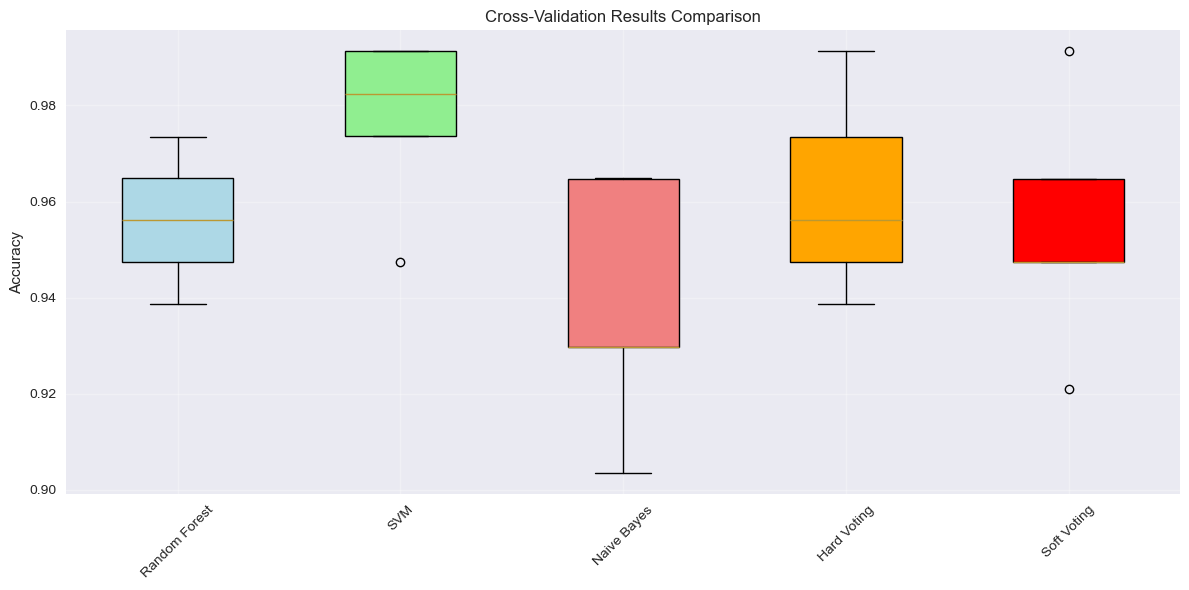


=== Statistical Significance Tests ===
Soft Voting vs Random Forest: p-value = 0.8262 ns
Soft Voting vs SVM: p-value = 0.0327 *
Soft Voting vs Naive Bayes: p-value = 0.0213 *
Soft Voting vs Hard Voting: p-value = 0.0989 ns


In [18]:
# Perform cross-validation comparison
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Models to compare
models_cv = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': Pipeline([('scaler', StandardScaler()), ('svm', SVC(probability=True, random_state=42))]),
    'Naive Bayes': GaussianNB(),
    'Hard Voting': VotingClassifier(estimators=estimators, voting='hard'),
    'Soft Voting': VotingClassifier(estimators=estimators, voting='soft')
}

cv_results = {}

print("Performing 5-fold cross-validation...")
for name, model in models_cv.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    cv_results[name] = scores
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# Visualize cross-validation results
plt.figure(figsize=(12, 6))
data_to_plot = [cv_results[name] for name in cv_results.keys()]
box_plot = plt.boxplot(data_to_plot, labels=cv_results.keys(), patch_artist=True)

# Color the boxes
colors = ['lightblue', 'lightgreen', 'lightcoral', 'orange', 'red']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('Accuracy')
plt.title('Cross-Validation Results Comparison')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Statistical significance test
from scipy import stats

# Compare soft voting vs individual models
soft_scores = cv_results['Soft Voting']
print("\n=== Statistical Significance Tests ===")
for name, scores in cv_results.items():
    if name != 'Soft Voting':
        t_stat, p_value = stats.ttest_rel(soft_scores, scores)
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        print(f"Soft Voting vs {name}: p-value = {p_value:.4f} {significance}")

## **⚠️ 13. Common Pitfalls and Best Practices**

### **Common Mistakes:**
- **Using highly correlated models**: Reduces ensemble benefits
- **Including poor-performing models**: Can hurt overall performance
- **Ignoring computational cost**: Voting multiplies training time
- **Not validating diversity**: High correlation between models reduces gains
- **Wrong voting type**: Hard voting with probability-based models

### **Best Practices:**
- **Ensure model diversity**: Use different algorithms, features, or training strategies
- **Use cross-validation**: Validate ensemble performance properly
- **Consider computational cost**: Balance performance gains vs. computational overhead
- **Prefer soft voting**: Generally performs better than hard voting
- **Weight by performance**: Give more weight to better-performing models
- **Monitor correlation**: Check that models make different errors

### **When to Use Voting:**
- ✅ **Multiple good models**: When you have several well-performing models
- ✅ **Risk reduction**: Need to reduce variance in predictions
- ✅ **Simple ensemble**: Want straightforward ensemble method
- ✅ **Different model types**: Combining different algorithm families

### **When NOT to Use Voting:**
- ❌ **One dominant model**: When one model significantly outperforms others
- ❌ **Highly correlated models**: When models make similar predictions
- ❌ **Strict time constraints**: When prediction speed is critical
- ❌ **Need interpretability**: When model transparency is required

## **🔄 14. Comparison with Other Ensemble Methods**

| Method | Complexity | Performance | Interpretability | Computational Cost |
|--------|------------|-------------|------------------|--------------------|
| **Voting** | Low | Good | Medium | Medium |
| **Bagging** | Low | Good | Medium | Medium |
| **Boosting** | Medium | Very Good | Low | High |
| **Stacking** | High | Excellent | Low | Very High |

### **When to Choose Voting:**
- Need simple, interpretable ensemble
- Have diverse, well-performing base models
- Want quick implementation
- Computational resources are limited

## **📚 15. Additional Resources**

### **Papers and Theory**
- [Ensemble Methods in Machine Learning](https://link.springer.com/chapter/10.1007/3-540-45014-9_1) - Thomas Dietterich's comprehensive review
- [Combining Pattern Classifiers](https://onlinelibrary.wiley.com/doi/book/10.1002/0471660264) - Kuncheva's book on ensemble methods

### **Documentation**
- [Scikit-learn VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)
- [Scikit-learn VotingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html)
- [Scikit-learn Ensemble Methods Guide](https://scikit-learn.org/stable/modules/ensemble.html)

### **Tutorials and Guides**
- [Voting Ensemble Tutorial](https://machinelearningmastery.com/voting-ensembles-with-python/)
- [Ensemble Learning Guide](https://towardsdatascience.com/ensemble-learning-techniques-explained-15ce870a4c34)

---

<h3 align="center">🗳️ Happy Modeling with Voting Ensembles! 🗳️</h3>